<a href="https://colab.research.google.com/github/maaz202/Artificial-Intelligence/blob/main/Self_Driving_Car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install hmmlearn
!pip install python-constraint


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py2.py3-none-any.whl size=24058 sha256=57b96d083163799ae9674bb3e80f03f0fd3879d469df42d501075aa7bd5b065e
  Stored in directory: /root/.cache/pip/wheels/2e/f2/2b/cb08b5fe129e4f69b7033061f256e5c551b0aa1160c2872aee
Successfully built python-constraint


Select the algorithm (BFS, DFS, A*, CSP, Hill Climbing, Local Beam Search, Alpha-Beta Pruning, Bayesian Search, HMM Search, Linear Regression Search): BFS
Solution found: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4)]


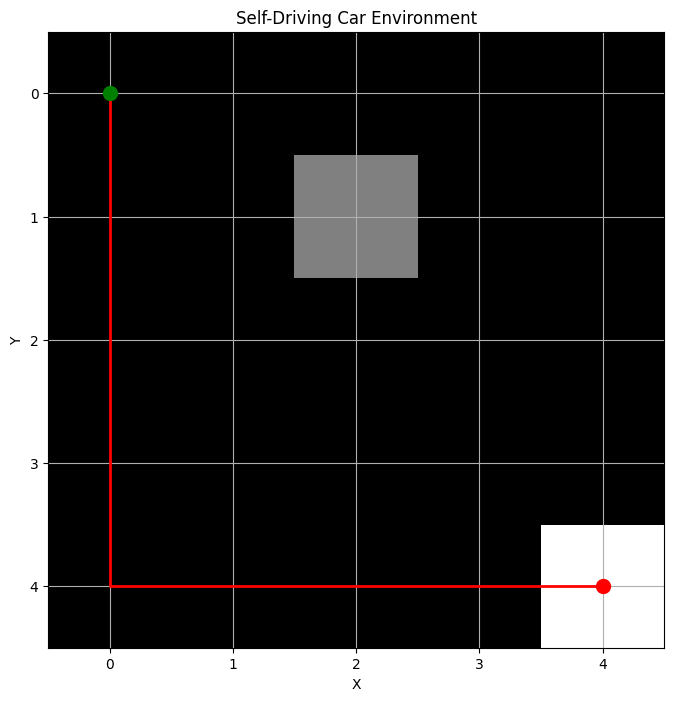

In [ ]:
from constraint import *
import gym
from gym import spaces
import numpy as np
from collections import deque
import heapq
import math
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from hmmlearn import hmm
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split


class Node:
    def __init__(self, state):
        self.state = state
        self.children = []
        self.value = 0  # Minimax value

class SelfDrivingCarEnv(gym.Env):
    """
    Custom Environment for the AI-based self-driving car simulation.
    Follows the gym interface.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, grid_size=(5, 5), start_state=(0, 0), goal_state=(4, 4), num_goals=1):
        super(SelfDrivingCarEnv, self).__init__()

        self.action_space = spaces.Discrete(4)  # Up, down, left, right
        self.observation_space = spaces.Box(low=0, high=255, shape=(np.prod(grid_size),), dtype=np.uint8)

        self.grid_size = grid_size
        self.start_state = start_state
        self.goal_state = goal_state
        self.num_goals = num_goals
        self.agent_position = start_state

        self.grid = self._create_grid()
        self.state_feature_matrix = self._create_state_feature_matrix()
        self.bayesian_model = self._create_bayesian_model()
        self.hmm_model = self._create_hmm_model()
        self.linear_regression_model = self._create_linear_regression_model()

    def _create_grid(self):
        grid = np.zeros(self.grid_size)
        # Add goals, barriers, etc.
        grid[self.goal_state] = 2  # Goal
        grid[1, 2] = 1  # Barrier
        return grid

    def _create_state_feature_matrix(self):
        # Generate a feature matrix for each state
        feature_matrix = np.zeros((self.grid_size[0] * self.grid_size[1], 4))
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                feature_matrix[i * self.grid_size[1] + j] = [i, j, self.grid[i, j] == 1, self.grid[i, j] == 2]
        return feature_matrix

    def _create_bayesian_model(self):
        # Create a Bayesian model for predicting the next state
        model = GaussianNB()
        return model

    def _create_hmm_model(self):
        # Create an HMM model for predicting the next state
        states = ["Up", "Down", "Left", "Right"]
        model = hmm.CategoricalHMM(n_components=len(states))
        model.startprob_ = np.array([0.25, 0.25, 0.25, 0.25])  # Equal initial probability for each state
        model.transmat_ = np.array([[0.7, 0.1, 0.1, 0.1],
                                   [0.1, 0.7, 0.1, 0.1],
                                   [0.1, 0.1, 0.7, 0.1],
                                   [0.1, 0.1, 0.1, 0.7]])  # Transition probabilities
        model.emissionprob_ = np.array([[0.9, 0.1, 0, 0],
                                       [0, 0.9, 0.1, 0],
                                       [0, 0, 0.9, 0.1],
                                       [0.1, 0, 0, 0.9]])  # Emission probabilities
        return model

    def _create_linear_regression_model(self):
        # Create a Linear Regression model for predicting the next state
        model = LinearRegression()
        return model

    def step(self, action):
        # Update agent position based on action
        if action == 0:  # Up
            self.agent_position = (self.agent_position[0], max(self.agent_position[1] - 1, 0))
        elif action == 1:  # Down
            self.agent_position = (self.agent_position[0], min(self.agent_position[1] + 1, self.grid_size[1] - 1))
        elif action == 2:  # Left
            self.agent_position = (max(self.agent_position[0] - 1, 0), self.agent_position[1])
        elif action == 3:  # Right
            self.agent_position = (min(self.agent_position[0] + 1, self.grid_size[0] - 1), self.agent_position[1])

        # Check for goals, barriers, etc.
        reward = 0
        done = False
        if self.agent_position == self.goal_state:
            reward = 100
            done = True
        elif self.grid[self.agent_position[0], self.agent_position[1]] == 1:  # Barrier
            reward = -10
            done = True

        # Update the Bayesian model
        state_feature = self.state_feature_matrix[self.agent_position[0] * self.grid_size[1] + self.agent_position[1]]
        self.bayesian_model.partial_fit([state_feature], [action])

        # Update the HMM model
        self.hmm_model.fit([action])

        # Update the Linear Regression model
        self.linear_regression_model.partial_fit([state_feature], [action])

        return self.grid.flatten(), reward, done, {}

    def reset(self):
        self.agent_position = self.start_state
        self.grid = self._create_grid()
        return self.grid.flatten()

    def render(self, mode='human', close=False):
        # Render the grid and the agent
        if close:
            return
        print(self.grid)

    def get_next_state(self, state, action):
    # Helper function to get the next state given the current state and action
        next_state = None
        if action == 0:  # Up
            next_state = (state[0], max(state[1] - 1, 0))
        elif action == 1:  # Down
            next_state = (state[0], min(state[1] + 1, self.grid_size[1] - 1))
        elif action == 2:  # Left
            next_state = (max(state[0] - 1, 0), state[1])
        elif action == 3:  # Right
            next_state = (min(state[0] + 1, self.grid_size[0] - 1), state[1])

        if next_state is None or (next_state[0] < 0 or next_state[0] >= self.grid_size[0] or next_state[1] < 0 or next_state[1] >= self.grid_size[1]) or self.grid[next_state[0], next_state[1]] == 1:  # Check if the new state is out of bounds or a barrier
            return None
        else:
            return next_state






def bfs_search(environment):
    start = environment.start_state
    frontier = deque([(start, [start])])
    explored = set()

    while frontier:
        current, path = frontier.popleft()
        if current == environment.goal_state:
            return path
        if current not in explored:
            explored.add(current)
            for action in range(environment.action_space.n):
                new_state = environment.get_next_state(current, action)
                if new_state is not None and new_state not in explored:
                    frontier.append((new_state, path + [new_state]))
    return None



def dfs_search(environment):
    start = environment.start_state
    frontier = [(start, [start])]
    explored = set()

    while frontier:
        current, path = frontier.pop()
        if current == environment.goal_state:
            return path
        if current not in explored:
            explored.add(current)
            for action in range(environment.action_space.n):
                new_state = environment.get_next_state(current, action)
                if new_state is not None and new_state not in explored:
                    frontier.append((new_state, path + [new_state]))
    return None


def heuristic(state, goal):
    # Euclidean distance heuristic
    if state is None:
        return float('inf')
    else:
        return ((state[0] - goal[0]) ** 2 + (state[1] - goal[1]) ** 2) ** 0.5


def a_star_search(environment):
    start = environment.start_state
    frontier = [(0, start, [start])]
    explored = set()

    while frontier:
        _, current, path = heapq.heappop(frontier)
        if current == environment.goal_state:
            return path
        if current not in explored:
            explored.add(current)
            for action in range(environment.action_space.n):
                new_state = environment.get_next_state(current, action)
                if new_state is not None:
                    new_cost = len(path) + 1
                    new_priority = new_cost + heuristic(new_state, environment.goal_state)
                    heapq.heappush(frontier, (new_priority, new_state, path + [new_state]))
    return None


def csp_solver(environment):
    problem = Problem()

    # Add variables (agent position)
    problem.addVariable("x", list(range(environment.grid_size[0])))
    problem.addVariable("y", list(range(environment.grid_size[1])))

    # Add constraints
    def is_valid_position(x, y):
        return environment.grid[x, y] != 1  # Check for barriers

    problem.addConstraint(is_valid_position, ["x", "y"])

    # Solve the problem
    solutions = problem.getSolutions()

    if solutions:
        # Reconstruct the path from the first solution
        solution = solutions[0]
        path = [(solution["x"], solution["y"])]
        current_state = (solution["x"], solution["y"])

        while current_state != environment.goal_state:
            for action in range(environment.action_space.n):
                new_state = environment.get_next_state(current_state, action)
                if new_state is not None and new_state not in path:
                    current_state = new_state
                    path.append(current_state)
                    break

        return path
    else:
        return None



def hill_climbing_search(environment):
    start = environment.start_state
    current_state = start
    path = [start]

    while current_state != environment.goal_state:
        # Check all possible actions from the current state
        best_action = None
        best_state = current_state
        best_cost = float('inf')

        for action in range(environment.action_space.n):
            new_state = environment.get_next_state(current_state, action)
            if new_state is not None and environment.grid[new_state[0], new_state[1]] != 1:  # Check if the new state is not a barrier
                new_cost = heuristic(new_state, environment.goal_state)
                if new_cost < best_cost:
                    best_action = action
                    best_state = new_state
                    best_cost = new_cost

        if best_action is None:
            # No better state found, return the current path
            return path

        current_state = best_state
        path.append(current_state)

    return path


def local_beam_search(environment, beam_width=3):
    start = environment.start_state
    frontier = [(start, [start], heuristic(start, environment.goal_state))]
    explored = set()

    while frontier:
        # Select the beam_width best states from the frontier
        frontier.sort(key=lambda x: x[2])
        states = [state[0] for state in frontier[:beam_width]]
        paths = [state[1] for state in frontier[:beam_width]]
        frontier = frontier[beam_width:]

        # Expand the selected states
        new_frontier = []
        for state, path in zip(states, paths):
            if state == environment.goal_state:
                return path
            if state not in explored:
                explored.add(state)
                for action in range(environment.action_space.n):
                    new_state = environment.get_next_state(state, action)
                    if new_state is not None and environment.grid[new_state[0], new_state[1]] != 1:  # Check if the new state is not a barrier
                        new_path = path + [new_state]
                        new_priority = heuristic(new_state, environment.goal_state)
                        new_frontier.append((new_state, new_path, new_priority))

        frontier.extend(new_frontier)

    return None


def alpha_beta_pruning(environment, max_depth=3):
    def min_value(node, alpha, beta, depth):
        if depth == 0 or environment.agent_position == environment.goal_state:
            return heuristic(node.state, environment.goal_state)

        node.value = math.inf
        for action in range(environment.action_space.n):
            new_state = environment.get_next_state(node.state, action)
            if environment.grid[new_state[0], new_state[1]] != 1:  # Check if the new state is not a barrier
                child = Node(new_state)
                node.children.append(child)
                node.value = min(node.value, max_value(child, alpha, beta, depth - 1))
                if node.value <= alpha:
                    return node.value
                beta = min(beta, node.value)
        return node.value

    def max_value(node, alpha, beta, depth):
        if depth == 0 or environment.agent_position == environment.goal_state:
            return heuristic(node.state, environment.goal_state)

        node.value = -math.inf
        for action in range(environment.action_space.n):
            new_state = environment.get_next_state(node.state, action)
            if environment.grid[new_state[0], new_state[1]] != 1:  # Check if the new state is not a barrier
                child = Node(new_state)
                node.children.append(child)
                node.value = max(node.value, min_value(child, alpha, beta, depth - 1))
                if node.value >= beta:
                    return node.value
                alpha = max(alpha, node.value)
        return node.value

    start = Node(environment.start_state)
    alpha_beta_pruning_result = max_value(start, -math.inf, math.inf, max_depth)

    # Reconstruct the path
    path = [start.state]
    current = start
    while current.state != environment.goal_state:
        if current.children:
            best_child = max(current.children, key=lambda child: child.value)
            path.append(best_child.state)
            current = best_child
        else:
            break  # No more children, exit the loop

    return path

def bayesian_search(environment):
    # Fit the Bayesian model
    X = environment.state_feature_matrix
    y = np.zeros(X.shape[0], dtype=int)  # Dummy labels, we don't need them for prediction
    environment.bayesian_model.fit(X, y)

    start = environment.start_state
    path = [start]
    current_state = start

    while current_state != environment.goal_state:
        # Use the Bayesian model to predict the next action
        state_feature = environment.state_feature_matrix[current_state[0] * environment.grid_size[1] + current_state[1]]
        predicted_action = environment.bayesian_model.predict([state_feature])[0]

        # Get the next state based on the predicted action
        next_state = environment.get_next_state(current_state, predicted_action)

        if environment.grid[next_state[0], next_state[1]] != 1:  # Check if the new state is not a barrier
            current_state = next_state
            path.append(current_state)
        else:
            # If the predicted action leads to a barrier, choose a random action
            action = np.random.randint(0, environment.action_space.n)
            next_state = environment.get_next_state(current_state, action)
            if environment.grid[next_state[0], next_state[1]] != 1:
                current_state = next_state
                path.append(current_state)

    return path

def hmm_search(environment):
    start = environment.start_state
    path = [start]
    current_state = start

    while current_state != environment.goal_state:
        # Use the HMM model to predict the next action
        predicted_action = environment.hmm_model.predict([environment.agent_position])[0]

        # Get the next state based on the predicted action
        next_state = environment.get_next_state(current_state, predicted_action)

        if environment.grid[next_state[0], next_state[1]] != 1:  # Check if the new state is not a barrier
            current_state = next_state
            path.append(current_state)
        else:
            # If the predicted action leads to a barrier, choose a random action
            action = np.random.randint(0, environment.action_space.n)
            next_state = environment.get_next_state(current_state, action)
            if environment.grid[next_state[0], next_state[1]] != 1:
                current_state = next_state
                path.append(current_state)

    return path

def _create_linear_regression_model(self):
    # Create a Linear Regression model for predicting the next state
    model = LinearRegression()
    return model

def linear_regression_search(environment):
    start = environment.start_state
    path = [start]
    current_state = start

    # Train the Linear Regression model
    X = environment.state_feature_matrix
    y = np.array([environment.action_space.n for _ in range(X.shape[0])]).reshape(-1, 1)
    environment.linear_regression_model.fit(X, y)

    while current_state != environment.goal_state:
        # Use the Linear Regression model to predict the next action
        state_feature = environment.state_feature_matrix[current_state[0] * environment.grid_size[1] + current_state[1]]
        predicted_action = environment.linear_regression_model.predict([state_feature])[0]

        # Get the next state based on the predicted action
        next_state = environment.get_next_state(current_state, int(predicted_action))

        if next_state is not None and environment.grid[next_state[0], next_state[1]] != 1:  # Check if the new state is not a barrier
            current_state = next_state
            path.append(current_state)
        else:
            # If the predicted action leads to a barrier, choose a random action
            action = np.random.randint(0, environment.action_space.n)
            next_state = environment.get_next_state(current_state, action)
            if next_state is not None and environment.grid[next_state[0], next_state[1]] != 1:
                current_state = next_state
                path.append(current_state)

    return path




def render_solution(environment, solution):
    plt.figure(figsize=(8, 8))
    plt.imshow(environment.grid, cmap='gray')

    # Plot the agent's path
    if solution:
        if isinstance(solution, list):
            x, y = zip(*solution)
            plt.plot(x, y, 'r-', linewidth=2)
        elif isinstance(solution, tuple):
            plt.plot([solution[0]], [solution[1]], 'r-', linewidth=2)
        else:
            print("Unsupported solution format.")
    else:
        print("No solution found.")

    # Plot the start and goal positions
    plt.plot(environment.start_state[0], environment.start_state[1], 'go', markersize=10)
    plt.plot(environment.goal_state[0], environment.goal_state[1], 'ro', markersize=10)

    plt.title('Self-Driving Car Environment')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()



def main():
    env = SelfDrivingCarEnv()

    algorithm = input("Select the algorithm (BFS, DFS, A*, CSP, Hill Climbing, Local Beam Search, Alpha-Beta Pruning, Bayesian Search, HMM Search, Linear Regression Search): ").lower()

    if algorithm == 'bfs':
        solution = bfs_search(env)
    elif algorithm == 'dfs':
        solution = dfs_search(env)
    elif algorithm == 'a*':
        solution = a_star_search(env)
    elif algorithm == 'csp':
        solution = csp_solver(env)
        if solution:
            print("Solution found:", solution)
        else:
            print("No solution found.")
        return
    elif algorithm == 'hill climbing':
        solution = hill_climbing_search(env)
    elif algorithm == 'local beam search':
        beam_width = int(input("Enter the beam width: "))
        solution = local_beam_search(env, beam_width)
    elif algorithm == 'alpha-beta pruning':
        max_depth = int(input("Enter the maximum depth: "))
        solution = alpha_beta_pruning(env, max_depth)
    elif algorithm == 'bayesian search':
        solution = bayesian_search(env)
    elif algorithm == 'hmm search':
        solution = hmm_search(env)
    elif algorithm == 'linear regression search':
        solution = linear_regression_search(env)
    else:
        print("Invalid algorithm selected.")
        return


    if solution:
        print("Solution found:", solution)
        render_solution(env, solution)
    else:
        print("No solution found.")

if __name__ == '__main__':
    main()

